(item_response_nba)=
# NBA Foul Analysis with Item Response Theory

:::{post} Apr 17, 2022
:tags: hierarchical model, case study, generalized linear model
:category: intermediate, tutorial
:author:  Michael Osthege, Lorenzo Toniazzi
:::

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

%matplotlib inline
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0b6


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Introduction
This tutorial shows an application of Bayesian Item Response Theory {cite:p}`fox2010bayesian` to NBA basketball foul calls data using PyMC. Based on Austin Rochford's blogpost [NBA Foul Calls and Bayesian Item Response Theory](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html).

### Motivation
Our scenario is that we observe a binary outcome (a foul being called or not) from an interaction (a basketball play) of two agents with two different roles (the player committing the alleged foul and the player disadvantaged in the play). Moreover, each committing or disadvantaged agent is an individual which might be observed several times (say LeBron James observed committing a foul in more than one play). Then it might be that not only the agent's role, but also the abilities of the single individual player contribute to the observed outcome. And so we'd like to __estimate the contribution to the observed outcome of each individual's (latent) ability as a committing or disadvantaged agent.__ This would allow us, for example, to rank players from more to less effective, quantify uncertainty in this ranking and discover extra hierarchical structures involved in foul calls. All pretty useful stuff! 
 

So how can we study this common and complex __multi-agent interaction__ scenario, with __hierarchical__ structures between  more than a thousand individuals? 

Despite the scenario's overwhelming complexity, Bayesian Item Response Theory combined with modern powerful statistical softwares allows for quite elegant and effective modeling options. One of these options employs a {term}`Generalized Linear Model` called [Rasch model](https://en.wikipedia.org/wiki/Rasch_model), which we now discuss in more detail.


### Rasch Model
We sourced our data from the official [NBA Last Two Minutes Reports](https://official.nba.com/2020-21-nba-officiating-last-two-minute-reports/) with game data between 2015 to 2021. In this dataset, each row `k`  is one play involving two players (the committing and the disadvantaged) where a foul has been either called or not. So we model the probability `p_k` that a referee calls a foul in play `k` as a function of the players involved. Hence we define two latent variables for each player, namely:
- `theta`: which estimates the player's ability to have a foul called when disadvantaged, and
- `b`: which estimates the player's ability  to have a foul not called when committing.

Note that the higher these player's parameters, the better the outcome for the player's team. These two parameters are then estimated using a standard Rasch model, by assuming the log-odds-ratio of `p_k` equals `theta-b` for the corresponding players involved in play `k`. Also, we place hierarchical hyperpriors on all `theta`'s and all `b`'s to account for shared abilities between players and largely different numbers of observations for different players.


### Discussion 
Our analysis gives an estimate of the latent skills `theta` and `b` for each player in terms of posterior distributions. We analyze this outcome in three ways. 

We first display the role of shared hyperpriors, by showing how posteriors of players with little observations are drawn to the league average.

Secondly, we rank the posteriors by their mean to view best and worst committing and disadvantaged players, and observe that several players still rank in the top 10 of the same model estimated in [Austin Rochford blogpost](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html) on different data.

Thirdly, we show how we spot that grouping payers by their position is likely to be an informative extra hierarchical layer to introduce in our model, and leave this as an exercise for the interested reader. Let us conclude by mentioning that this opportunity of easily adding informed hierarchical structure to a model is one of the features that makes Bayesian modelling very flexible and powerful for quantifying uncertainty in scenarios where introducing (or discovering) problem-specific knowledge is crucial.


The analysis in this notebook is performed in four main steps: 

1. Data collection and processing.
2. Definition and instantiation of the Rasch model. 
3. Posterior sampling and convergence checks.
4. Analysis of the posterior results.

## Data collection and processing
We first import data from the original data set, which can be found at [this URL](https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv). Each row corresponds to a play between the NBA seasons 2015-16 and 2020-21. We imported only five columns, namely
- `committing`: the  name of the committing player in the play.
- `disadvantaged`: the name of the disadvantaged player in the play.
- `decision`: the reviewed decision of the play, which can take four values, namely:
    - `CNC`: correct noncall, `INC`: incorrect noncall, `IC`: incorrect call, `CC`: correct call.
- `committing_position`: the position of the committing player which can take values
    - `G`: guard, `F`: forward, `C`: center, `G-F`, `F-G`, `F-C`, `C-F`.
- `disadvantaged_position`: the position of the disadvantaged player, with possible values as above.

We note that we  already removed  from the original  dataset the plays where less than two players are involved (for example travel calls or clock violations). Also, the original dataset does not contain information on the players' position, which we added ourselves.

In [3]:
try:
    df_orig = pd.read_csv(os.path.join("..", "data", "item_response_nba.csv"), index_col=0)
except FileNotFoundError:
    df_orig = pd.read_csv(pm.get_data("item_response_nba.csv"), index_col=0)
df_orig.head()

,committing,disadvantaged,decision,committing_position,disadvantaged_position
play_id,,,,,
1,Avery Bradley,Stephen Curry,CNC,G,G
3,Isaiah Thomas,Andre Iguodala,CNC,G,G-F
4,Jae Crowder,Harrison Barnes,INC,F,F
6,Draymond Green,Isaiah Thomas,CC,F,G
7,Avery Bradley,Stephen Curry,CC,G,G


We now process our data in three steps:
 1. We create a dataframe `df` by removing the position information from `df_orig`, and we create a dataframe `df_position` collecting all players with the respective position. (This last dataframe will not be used until the very end of the notebook.)
 2. We add a  column to `df`, called `foul_called`, that assigns 1 to a play if a foul was called, and 0 otherwise.
 3. We assign IDs to committing and disadvantaged players and use this indexing to identify the respective players in each observed play.

Finally, we display the head of our main dataframe `df` along with some basic statistics.

In [4]:
# 1. Construct df and df_position
df = df_orig[["committing", "disadvantaged", "decision"]]

df_position = pd.concat(
    [
        df_orig.groupby("committing").committing_position.first(),
        df_orig.groupby("disadvantaged").disadvantaged_position.first(),
    ]
).to_frame()
df_position = df_position[~df_position.index.duplicated(keep="first")]
df_position.index.name = "player"
df_position.columns = ["position"]

# 2. Create the binary foul_called variable
def foul_called(decision):
    """Correct and incorrect noncalls (CNC and INC) take value 0.
    Correct and incorrect calls (CC and IC) take value 1.
    """
    out = 0
    if (decision == "CC") | (decision == "IC"):
        out = 1
    return out


df = df.assign(foul_called=lambda df: df["decision"].apply(foul_called))

# 3 We index observed calls by committing and disadvantaged players
committing_observed, committing = pd.factorize(df.committing, sort=True)
disadvantaged_observed, disadvantaged = pd.factorize(df.disadvantaged, sort=True)
df.index.name = "play_id"

# Display of main dataframe with some statistics
print(f"Number of observed plays: {len(df)}")
print(f"Number of disadvanteged players: {len(disadvantaged)}")
print(f"Number of committing players: {len(committing)}")
print(f"Global probability of a foul being called: " f"{100*round(df.foul_called.mean(),3)}%\n\n")
df.head()

Number of observed plays: 46861
Number of disadvanteged players: 770
Number of committing players: 789
Global probability of a foul being called: 23.3%




,committing,disadvantaged,decision,foul_called
play_id,,,,
1,Avery Bradley,Stephen Curry,CNC,0
3,Isaiah Thomas,Andre Iguodala,CNC,0
4,Jae Crowder,Harrison Barnes,INC,0
6,Draymond Green,Isaiah Thomas,CC,1
7,Avery Bradley,Stephen Curry,CC,1


## Item Response Model

### Model definition

We denote by:
- $N_d$ and $N_c$ the number of disadvantaged and committing players, respectively, 
- $K$ the number of plays,
- $k$ a play, 
- $y_k$ the observed call/noncall in play $k$,
- $p_k$ the probability of a foul being called in play $k$,
- $i(k)$ the disadvantaged player in play $k$, and by
- $j(k)$ the committing player in play $k$.

We assume that each disadvantaged player is described by the latent variable: 
- $\theta_i$ for $i=1,2,...,N_d$,

and each committing player is described by the latent variable: 
- $b_j$ for $j=1,2,...,N_c$.

Then we model each observation $y_k$ as the result of an independent Bernoulli trial with probability $p_k$, where

$$
p_k =\text{sigmoid}(\eta_k)=\left(1+e^{-\eta_k}\right)^{-1},\quad\text{with}\quad \eta_k=\theta_{i(k)}-b_{j(k)},
$$

for $k=1,2,...,K$, by defining (via a [non-centered parametrisation](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/))

\begin{align*}
\theta_{i}&= \sigma_\theta\Delta_{\theta,i}+\mu_\theta\sim \text{Normal}(\mu_\theta,\sigma_\theta^2),  &i=1,2,...,N_d,\\
b_{j}&= \sigma_b\Delta_{b,j}\sim \text{Normal}(0,\sigma_b^2), &j=1,2,...,N_c,
\end{align*}

with priors/hyperpriors

\begin{align*}
\Delta_{\theta,i}&\sim \text{Normal}(0,1),  &i=1,2,...,N_d,\\
\Delta_{b,j}&\sim \text{Normal}(0,1), &j=1,2,...,N_c,\\
\mu_\theta&\sim \text{Normal}(0,100),\\
\sigma_\theta &\sim \text{HalfCauchy}(2.5),\\
\sigma_b &\sim \text{HalfCauchy}(2.5).
\end{align*}

Note that $p_k$ is always dependent on $\mu_\theta,\,\sigma_\theta$ and $\sigma_b$ ("pooled priors") and also depends on the actual players involved in the play due to  $\Delta_{\theta,i}$ and $\Delta_{b,j}$ ("unpooled priors"). This means our model features partial pooling. Morover, note that we do not pool $\theta$'s with $b$'s, hence assuming these skills are independent even for the same player. Also, note that  we normalised the mean of $b_{j}$ to zero. 

Finally, notice how we worked backwards from our data to construct this model. This is a very natural way to construct a model, allowing us to quickly see how each variable connects to others and their intuition. Meanwhile, when instantiating the model below, the construction goes in the opposite direction, i.e. starting from priors and moving up to the observations.

### PyMC implementation
We now implement the model above in PyMC. Note that, to easily keep track of the players (as we have hundreds of them being both committing and disadvantaged), we make use of the `coords` argument for {class}`pymc.Model`. (For tutorials on this functionality see the notebook {ref}`data_container` or [this blogpost](https://oriolabrilpla.cat/python/arviz/pymc3/xarray/2020/09/22/pymc3-arviz.html).) We choose our priors to be the same as in [Austin Rochford's post](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html), to make the comparison consistent.

In [5]:
coords = {"disadvantaged": disadvantaged, "committing": committing}

with pm.Model(coords=coords) as model:

    # Data
    foul_called_observed = pm.Data("foul_called_observed", df.foul_called, mutable=False)

    # Hyperpriors
    mu_theta = pm.Normal("mu_theta", 0.0, 100.0)
    sigma_theta = pm.HalfCauchy("sigma_theta", 2.5)
    sigma_b = pm.HalfCauchy("sigma_b", 2.5)

    # Priors
    Delta_theta = pm.Normal("Delta_theta", 0.0, 1.0, dims="disadvantaged")
    Delta_b = pm.Normal("Delta_b", 0.0, 1.0, dims="committing")

    # Deterministic
    theta = pm.Deterministic("theta", Delta_theta * sigma_theta + mu_theta, dims="disadvantaged")
    b = pm.Deterministic("b", Delta_b * sigma_b, dims="committing")
    eta = pm.Deterministic("eta", theta[disadvantaged_observed] - b[committing_observed])

    # Likelihood
    y = pm.Bernoulli("y", logit_p=eta, observed=foul_called_observed)

We now plot our model to show the hierarchical structure (and the non-centered parametrisation) on the variables `theta` and `b`.

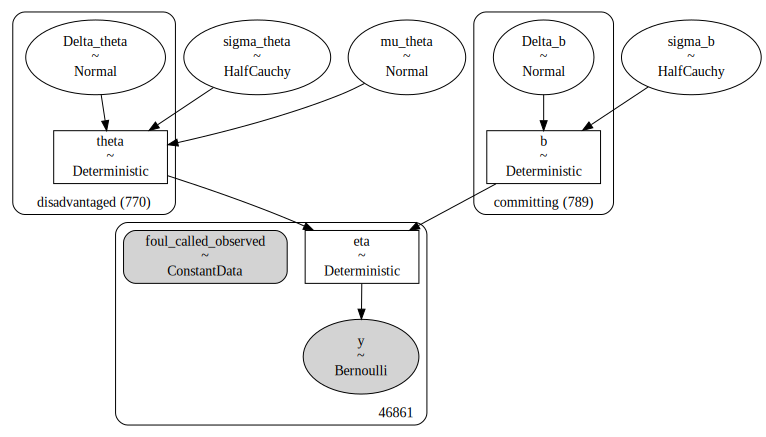

In [6]:
pm.model_to_graphviz(model)

## Sampling and convergence

We now sample from our Rasch model.

In [7]:
with model:
    trace = pm.sample(1000, tune=1500, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/mas/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_theta, sigma_theta, sigma_b, Delta_theta, Delta_b]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 426 seconds.


We plot below the energy difference of the obtained trace. Also, we assume our sampler has converged as it passed all automatic PyMC convergence checks.

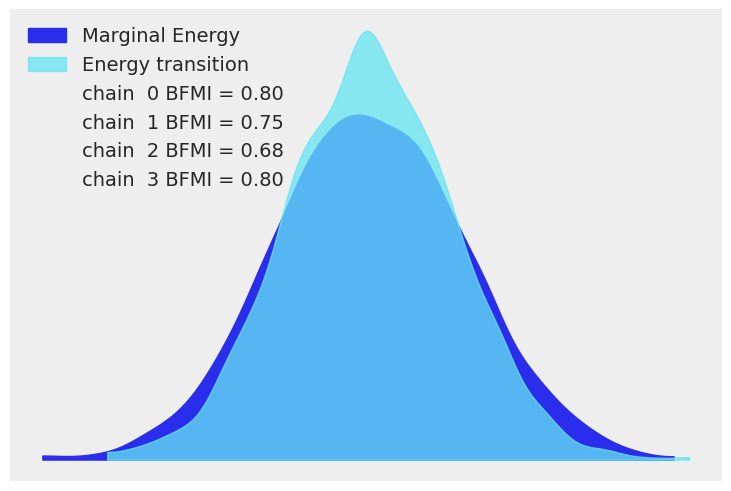

In [8]:
az.plot_energy(trace);

## Posterior analysis
### Visualisation of partial pooling
Our first check is to plot 
- y: the difference between the raw mean probability (from the data) and the posterior mean probability for each disadvantaged and committing player
- x: as a function of the number of observations per disadvantaged and committing player.

These plots show, as expected, that the hierarchical structure of our model tends to estimate posteriors towards the global mean for players with a low amount of observations.

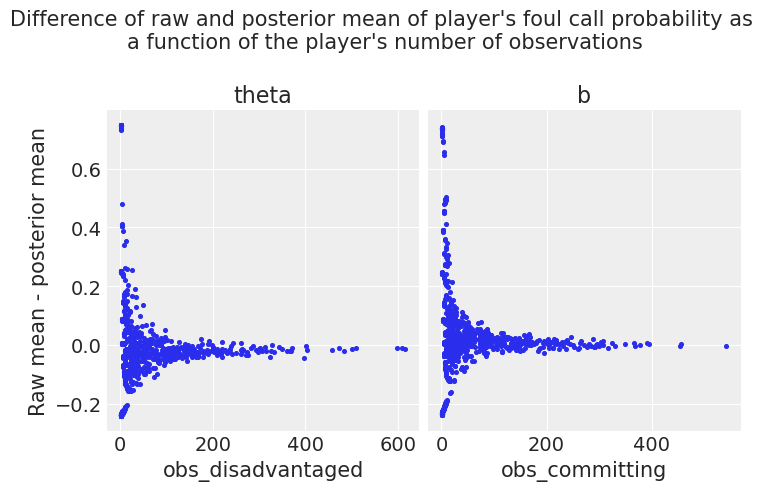

In [9]:
# Global posterior means of μ_theta and μ_b
mu_theta_mean, mu_b_mean = trace.posterior["mu_theta"].mean(), 0
# Raw mean from data of each disadvantaged player
disadvantaged_raw_mean = df.groupby("disadvantaged")["foul_called"].mean()
# Raw mean from data of each committing player
committing_raw_mean = df.groupby("committing")["foul_called"].mean()
# Posterior mean of each disadvantaged player
disadvantaged_posterior_mean = (
    1 / (1 + np.exp(-trace.posterior["theta"].mean(dim=["chain", "draw"]))).to_pandas()
)
# Posterior mean of each committing player
committing_posterior_mean = (
    1
    / (1 + np.exp(-(mu_theta_mean - trace.posterior["b"].mean(dim=["chain", "draw"])))).to_pandas()
)

# Compute difference of raw and posterior mean for each
# disadvantaged and committing player
def diff(a, b):
    return a - b


df_disadvantaged = pd.DataFrame(
    disadvantaged_raw_mean.combine(disadvantaged_posterior_mean, diff),
    columns=["Raw - posterior mean"],
)
df_committing = pd.DataFrame(
    committing_raw_mean.combine(committing_posterior_mean, diff), columns=["Raw - posterior mean"]
)
# Add the number of observations for each disadvantaged and committing player
df_disadvantaged = df_disadvantaged.assign(obs_disadvantaged=df["disadvantaged"].value_counts())
df_committing = df_committing.assign(obs_committing=df["committing"].value_counts())

# Plot the difference between raw and posterior means as a funciton of
# the number of observations
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle(
    "Difference of raw and posterior mean of player's foul call probability as "
    "\na function of the player's number of observations\n",
    fontsize=15,
)
ax1.scatter(data=df_disadvantaged, x="obs_disadvantaged", y="Raw - posterior mean", s=7, marker="o")
ax1.set_title("theta")
ax1.set_ylabel("Raw mean - posterior mean")
ax1.set_xlabel("obs_disadvantaged")
ax2.scatter(data=df_committing, x="obs_committing", y="Raw - posterior mean", s=7)
ax2.set_title("b")
ax2.set_xlabel("obs_committing")
plt.show()

### Top and bottom committing and disadvantaged players 
As we successfully estimated the skills of disadvantaged (`theta`) and committing (`b`) players, we can finally check which players perform better and worse in our model.
So we now plot our posteriors using forest plots. We plot the 10 top and bottom players ranked with respect to the latent skill `theta` and `b`, respectively.

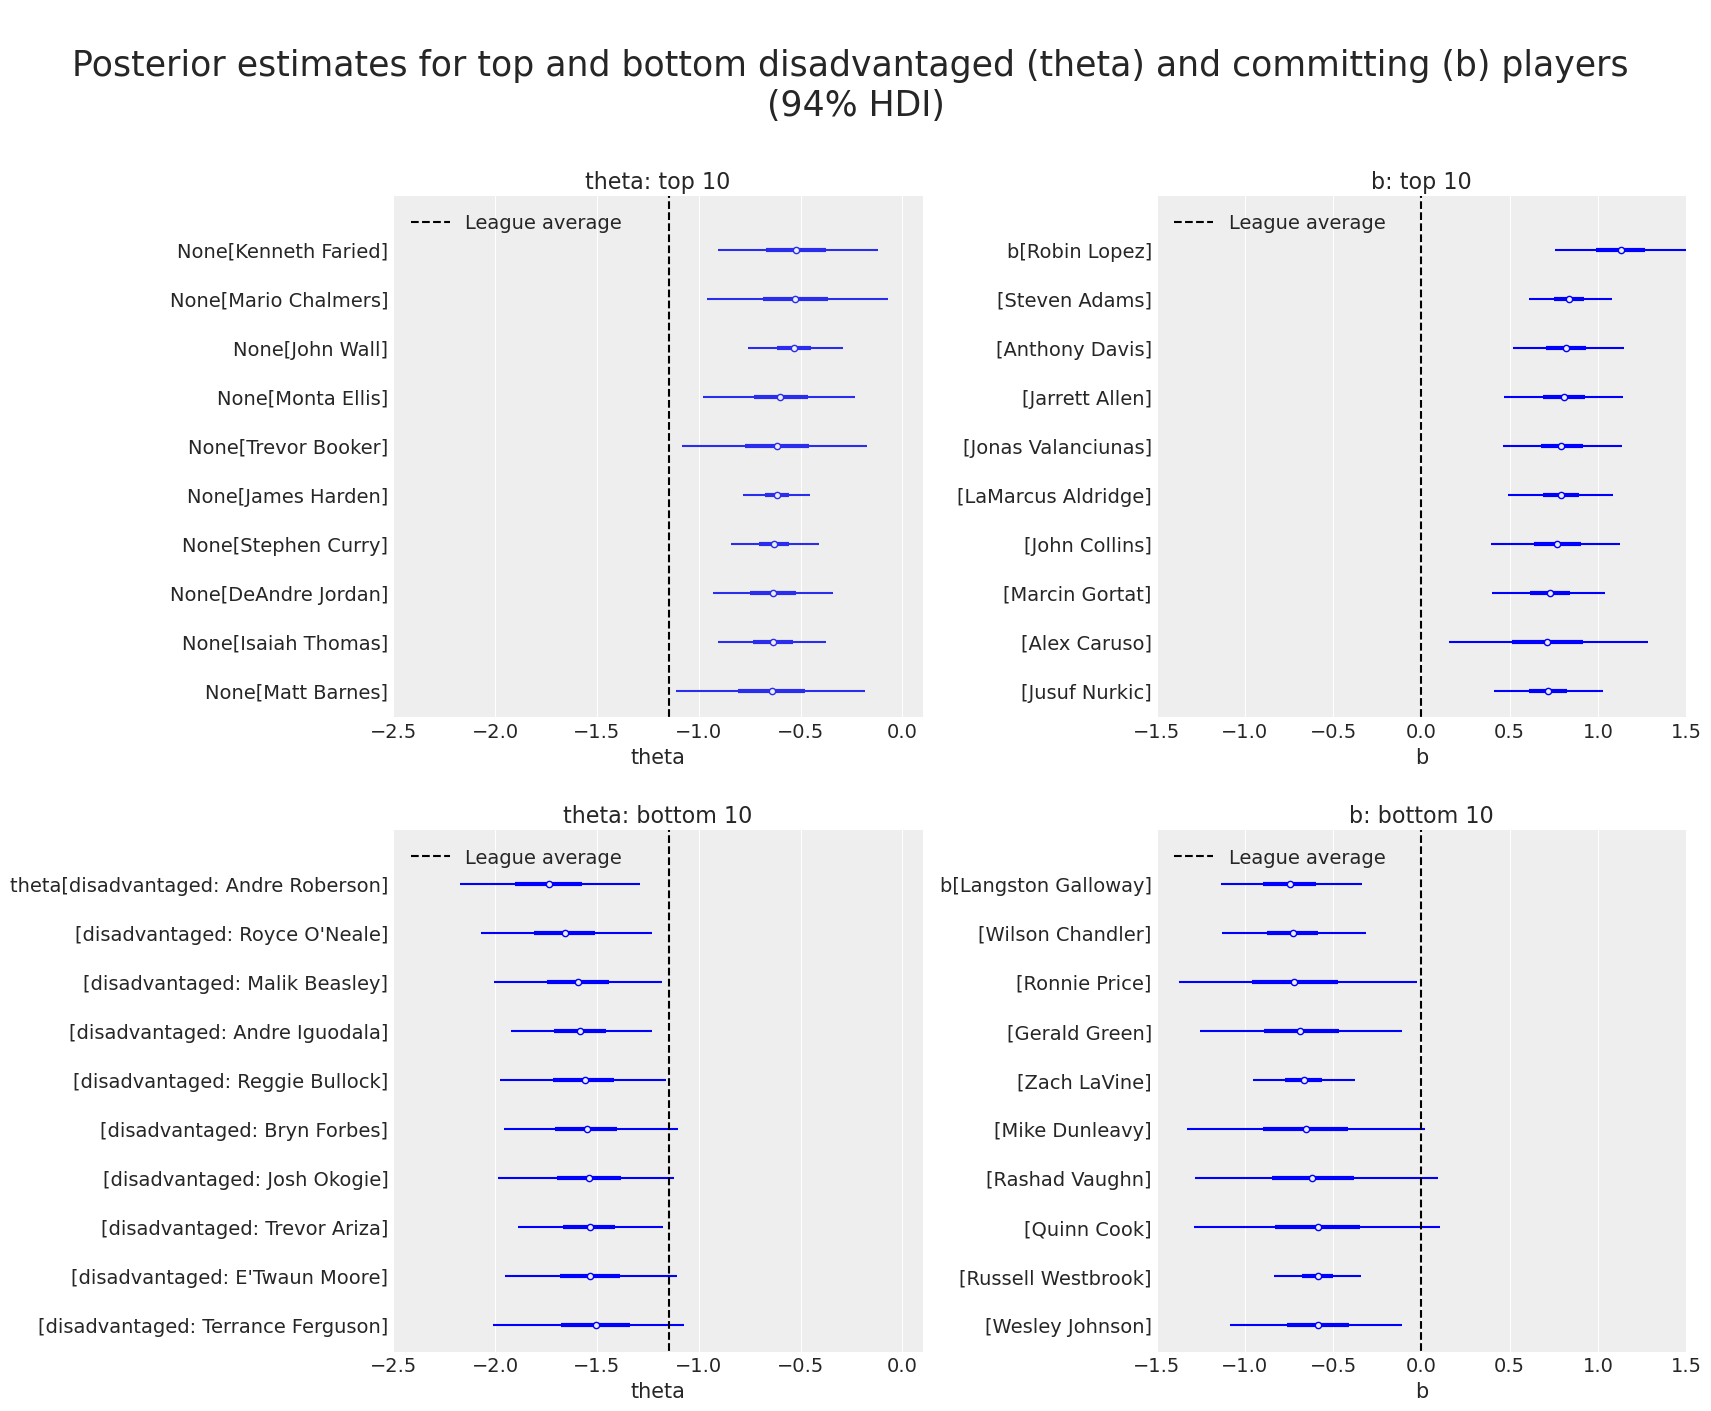

In [10]:
def order_posterior(inferencedata, var, bottom_bool):
    xarray_ = inferencedata.posterior[var].mean(dim=["chain", "draw"])
    return xarray_.sortby(xarray_, ascending=bottom_bool)


top_theta, bottom_theta = (
    order_posterior(trace, "theta", False),
    order_posterior(trace, "theta", True),
)
top_b, bottom_b = (order_posterior(trace, "b", False), order_posterior(trace, "b", True))

amount = 10  # How many top players we want to display in each cathegory

fig = plt.figure(figsize=(17, 14))
fig.suptitle(
    "\nPosterior estimates for top and bottom disadvantaged (theta) and "
    "committing (b) players \n(94% HDI)\n",
    fontsize=25,
)
theta_top_ax = fig.add_subplot(221)
b_top_ax = fig.add_subplot(222)
theta_bottom_ax = fig.add_subplot(223, sharex=theta_top_ax)
b_bottom_ax = fig.add_subplot(224, sharex=b_top_ax)

# theta: plot top
az.plot_forest(
    trace,
    var_names=["theta"],
    combined=True,
    coords={"disadvantaged": top_theta[:amount].coords["disadvantaged"]},
    ax=theta_top_ax,
    labeller=az.labels.NoVarLabeller(),
)
theta_top_ax.set_title(f"theta: top {amount}")
theta_top_ax.set_xlabel("theta\n")
theta_top_ax.set_xlim(xmin=-2.5, xmax=0.1)
theta_top_ax.vlines(mu_theta_mean, -1, amount, "k", "--", label=("League average"))
theta_top_ax.legend(loc=2)


# theta: plot bottom
az.plot_forest(
    trace,
    var_names=["theta"],
    colors="blue",
    combined=True,
    coords={"disadvantaged": bottom_theta[:amount].coords["disadvantaged"]},
    ax=theta_bottom_ax,
    labeller=az.labels.DimCoordLabeller(),
)
theta_bottom_ax.set_title(f"theta: bottom {amount}")
theta_bottom_ax.set_xlabel("theta")
theta_bottom_ax.vlines(mu_theta_mean, -1, amount, "k", "--", label=("League average"))
theta_bottom_ax.legend(loc=2)

# b: plot top
az.plot_forest(
    trace,
    var_names=["b"],
    colors="blue",
    combined=True,
    coords={"committing": top_b[:amount].coords["committing"]},
    ax=b_top_ax,
)
b_top_ax.set_title(f"b: top {amount}")
b_top_ax.set_xlabel("b\n")
b_top_ax.set_xlim(xmin=-1.5, xmax=1.5)
b_top_ax.vlines(0, -1, amount, "k", "--", label="League average")
b_top_ax.legend(loc=2)

# b: plot bottom
az.plot_forest(
    trace,
    var_names=["b"],
    colors="blue",
    combined=True,
    coords={"committing": bottom_b[:amount].coords["committing"]},
    ax=b_bottom_ax,
)
b_bottom_ax.set_title(f"b: bottom {amount}")
b_bottom_ax.set_xlabel("b")
b_bottom_ax.vlines(0, -1, amount, "k", "--", label="League average")
b_bottom_ax.legend(loc=2)
plt.show();

By visiting [Austin Rochford post](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html) and checking the analogous table for the Rasch model there (which uses data from the 2016-17 season),  the reader can see that several top players in both skills are still in the top 10 with our larger data set (covering seasons 2015-16 to 2020-21).

### Discovering extra hierarchical structure

A natural question to ask is whether players skilled as disadvantaged players (i.e. players with high `theta`) are also likely to be skilled as committing players  (i.e. with high `b`), and the other way around. So, the next two plots show the `theta` (resp. `b`) score for the top players with respect to `b` ( resp.`theta`).

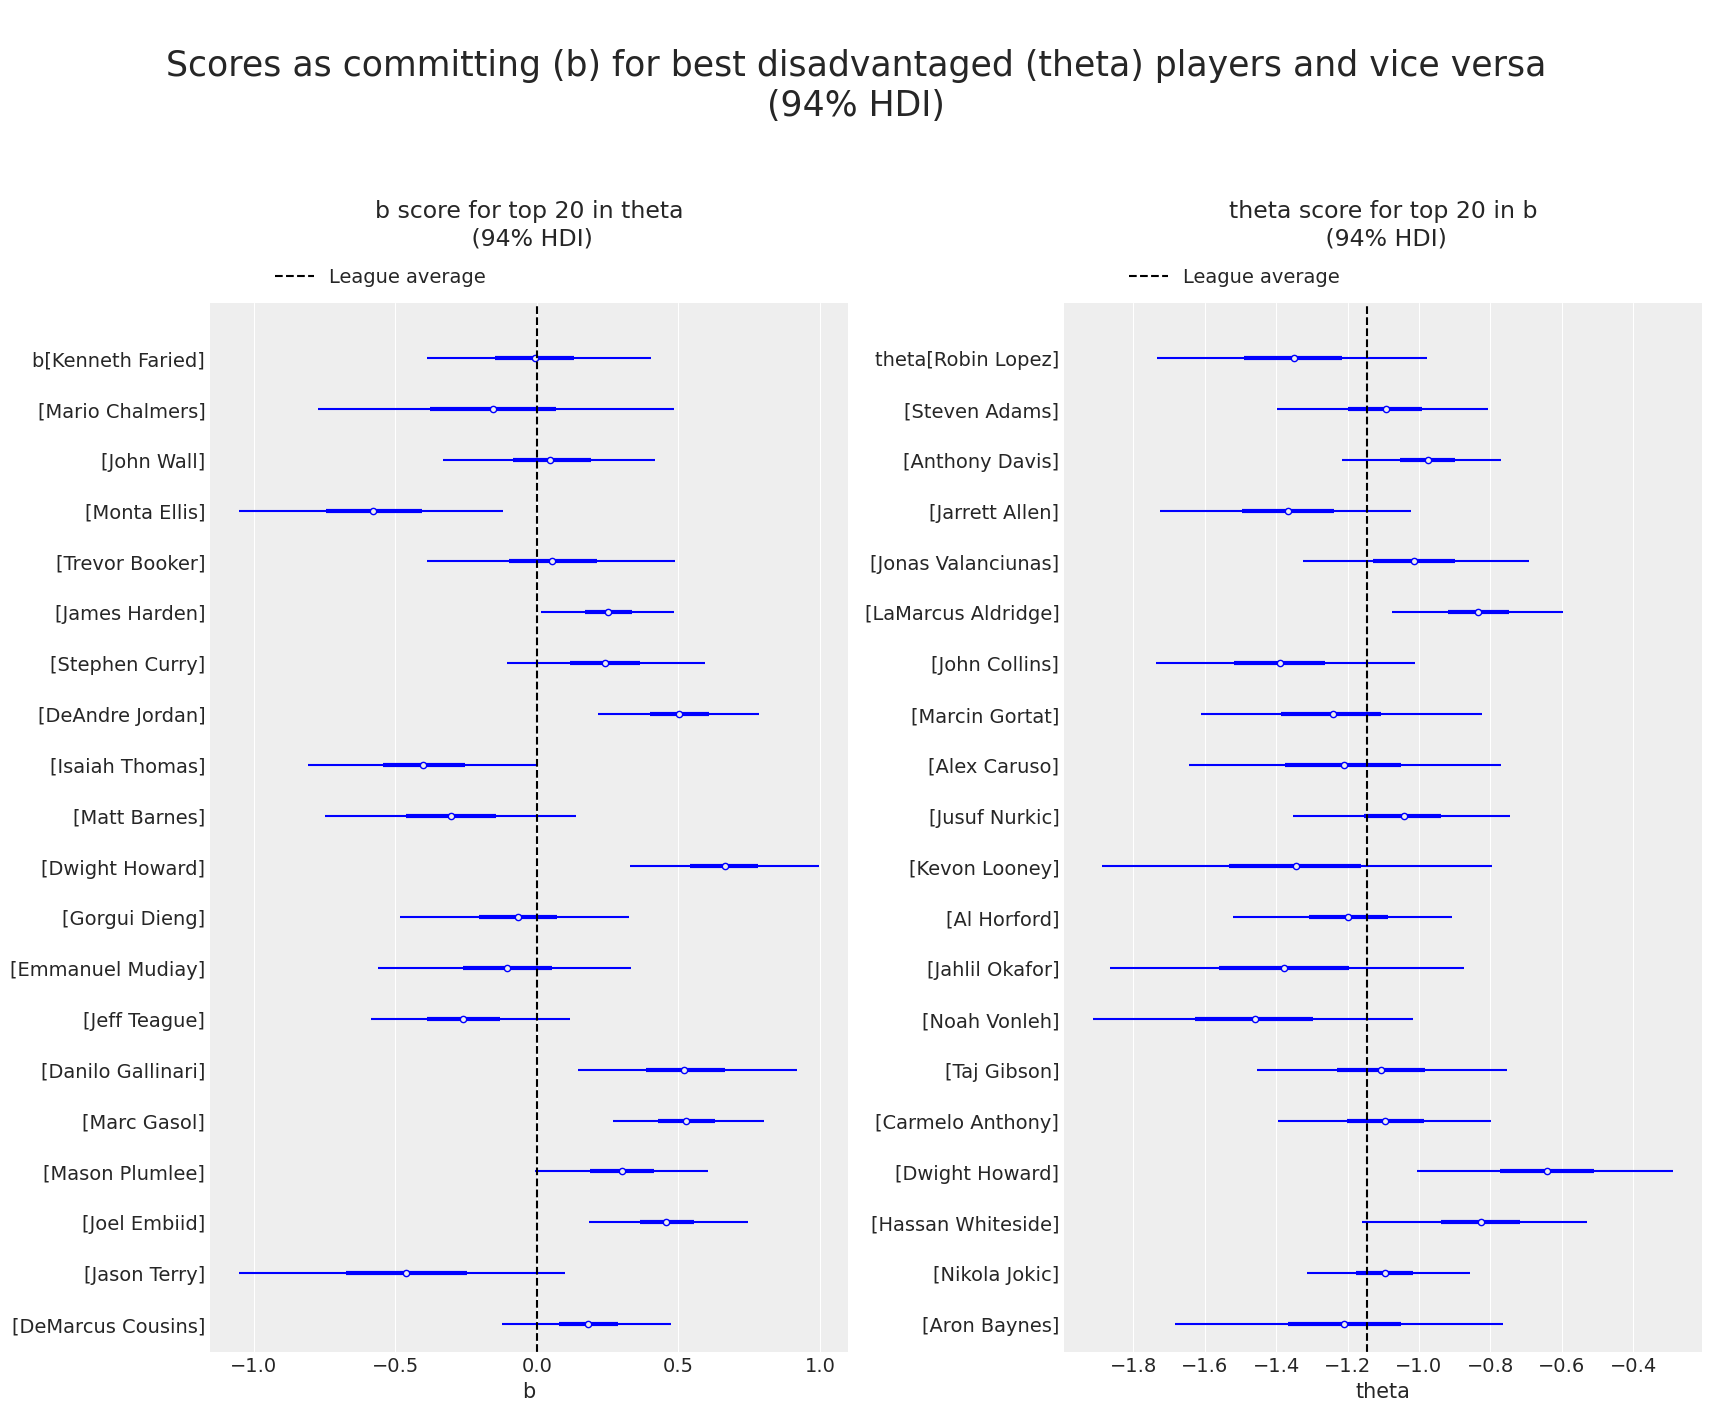

In [11]:
amount = 20  # How many top players we want to display
top_theta_players = top_theta["disadvantaged"][:amount].to_dict()["data"]
top_b_players = top_b["committing"][:amount].to_dict()["data"]

top_theta_in_committing = set(committing).intersection(set(top_theta_players))
top_b_in_disadvantaged = set(disadvantaged).intersection(set(top_b_players))
if (len(top_theta_in_committing) < amount) | (len(top_b_in_disadvantaged) < amount):
    print(
        f"Some players in the top {amount} for theta (or b) do not have observations for b (or theta).\n",
        "Plot not shown",
    )
else:
    fig = plt.figure(figsize=(17, 14))
    fig.suptitle(
        "\nScores as committing (b) for best disadvantaged (theta) players"
        " and vice versa"
        "\n(94% HDI)\n",
        fontsize=25,
    )
    b_top_theta = fig.add_subplot(121)
    theta_top_b = fig.add_subplot(122)

    az.plot_forest(
        trace,
        var_names=["b"],
        colors="blue",
        combined=True,
        coords={"committing": top_theta_players},
        figsize=(7, 7),
        ax=b_top_theta,
    )
    b_top_theta.set_title(f"\nb score for top {amount} in theta\n (94% HDI)\n\n", fontsize=17)
    b_top_theta.set_xlabel("b")
    b_top_theta.vlines(mu_b_mean, -1, amount, color="k", ls="--", label="League average")
    b_top_theta.legend(loc="upper right", bbox_to_anchor=(0.46, 1.05))

    az.plot_forest(
        trace,
        var_names=["theta"],
        colors="blue",
        combined=True,
        coords={"disadvantaged": top_b_players},
        figsize=(7, 7),
        ax=theta_top_b,
    )
    theta_top_b.set_title(f"\ntheta score for top {amount} in b\n (94% HDI)\n\n", fontsize=17)
    theta_top_b.set_xlabel("theta")
    theta_top_b.vlines(mu_theta_mean, -1, amount, color="k", ls="--", label="League average")
    theta_top_b.legend(loc="upper right", bbox_to_anchor=(0.46, 1.05));

These plots suggest that scoring high in `theta` does not correlate with high or low scores in `b`. Moreover, with a little knowledge of NBA basketball, one can visually note that a higher score in `b` is expected from players playing center or forward rather than guards or point guards. 
Given the last observation, we decide to plot a histogram for the occurence of different positions for top disadvantaged (`theta`) and committing (`b`) players. Interestingly, we see below that the largest share of best disadvantaged players are guards, meanwhile, the largest share of best committing players are centers (and at the same time a very small share of guards).

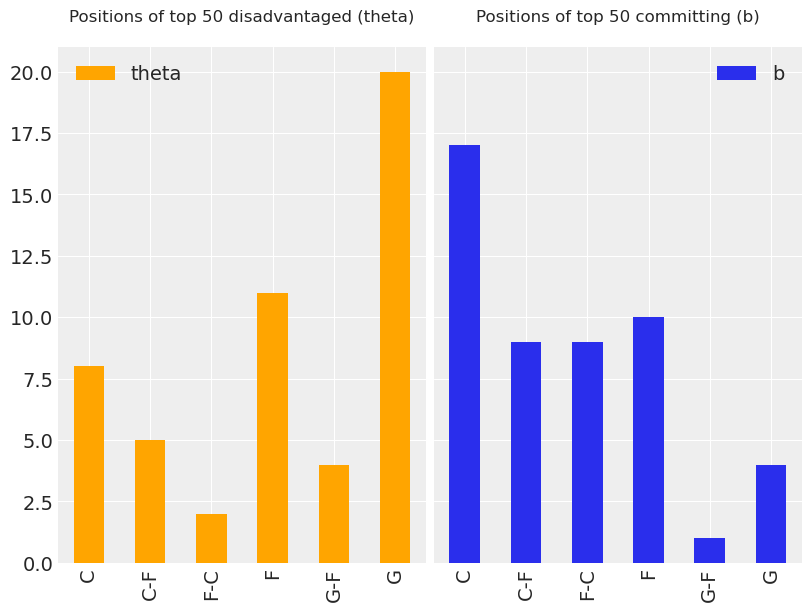

In [12]:
amount = 50  # How many top players we want to display
top_theta_players = top_theta["disadvantaged"][:amount].to_dict()["data"]
top_b_players = top_b["committing"][:amount].to_dict()["data"]

positions = ["C", "C-F", "F-C", "F", "G-F", "G"]

# Histogram of positions of top disadvantaged players
fig = plt.figure(figsize=(8, 6))
top_theta_position = fig.add_subplot(121)
df_position.loc[df_position.index.isin(top_theta_players)].position.value_counts().loc[
    positions
].plot.bar(ax=top_theta_position, color="orange", label="theta")
top_theta_position.set_title(f"Positions of top {amount} disadvantaged (theta)\n", fontsize=12)
top_theta_position.legend(loc="upper left")

# Histogram of positions of top committing players
top_b_position = fig.add_subplot(122, sharey=top_theta_position)
df_position.loc[df_position.index.isin(top_b_players)].position.value_counts().loc[
    positions
].plot.bar(ax=top_b_position, label="b")
top_b_position.set_title(f"Positions of top {amount} committing (b)\n", fontsize=12)
top_b_position.legend(loc="upper right");

The histograms above suggest that it might be appropriate to add a hierarchical layer to our model. Namely, group disadvantaged and committing players by the respective positions to account for the role of position in evaluating the latent skills `theta` and `b`. This can be done in our Rasch model by imposing mean and variance hyperpriors for each player grouped by the positions, which is left as an exercise for the reader. To this end, notice that the dataframe `df_orig` is set up precisely to add this hierarchical structure. Have fun!

## Authors
 
* Adapted from Austin Rochford's [blogpost on NBA Foul Calls and Bayesian Item Response Theory](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html) by [Lorenzo Toniazzi](https://github.com/ltoniazzi) on  3 Jul 2021 ([PR181](https://github.com/pymc-devs/pymc-examples/pull/181))
* Re-executed by [Michael Osthege](https://github.com/michaelosthege) on  10 Jan 2022 ([PR266](https://github.com/pymc-devs/pymc-examples/pull/266))
* Updated by [Lorenzo Toniazzi](https://github.com/ltoniazzi) on  15 Apr 2022 ([PR309](https://github.com/pymc-devs/pymc-examples/pull/309))

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Tue Apr 12 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

aesara: 2.5.1
aeppl : 0.0.27
xarray: 2022.3.0

pandas    : 1.4.2
arviz     : 0.12.0
pymc      : 4.0.0b6
matplotlib: 3.5.1
numpy     : 1.22.3

Watermark: 2.3.0



:::{include} ../page_footer.md
:::